# Imports

In [1]:
!pip install -U vit-keras

In [2]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.5 MB/s 


In [3]:
import random
from datetime import datetime
import numpy as np
import keras 

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import layers, regularizers
from tensorflow.keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.layers import AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from vit_keras import vit

import seaborn as sns

import matplotlib.pyplot as plt

# GPU Info

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 23 21:55:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset Setup

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
!mkdir /content/dataset

In [7]:
!unzip '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/1

# Hyperparameters Setup

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_EPOCHS = 100
CLASS_COUNT = 2

# Model Setup

In [9]:
DF_TRAIN = '/content/dataset/Brain_Data_Organised/Train'
DF_TEST  = '/content/dataset/Brain_Data_Organised/Test'

# images generator
train_gen = ImageDataGenerator(rescale = 1./255,
                               validation_split = 0.2, 
                               horizontal_flip = True)
test_gen = ImageDataGenerator(rescale = 1./255)

# load training and validating images from directory
train_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'training',
                                          seed = 956,
                                          shuffle = True,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary')

valid_set = train_gen.flow_from_directory(DF_TRAIN,
                                          subset = 'validation',
                                          seed = 343,
                                          shuffle = False,
                                          batch_size = BATCH_SIZE,
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary')

test_set  = test_gen.flow_from_directory(DF_TEST,
                                         seed = 657,
                                         shuffle = False,
                                         batch_size = BATCH_SIZE,
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'binary')

STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_VALID = valid_set.n // valid_set.batch_size

Found 1801 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


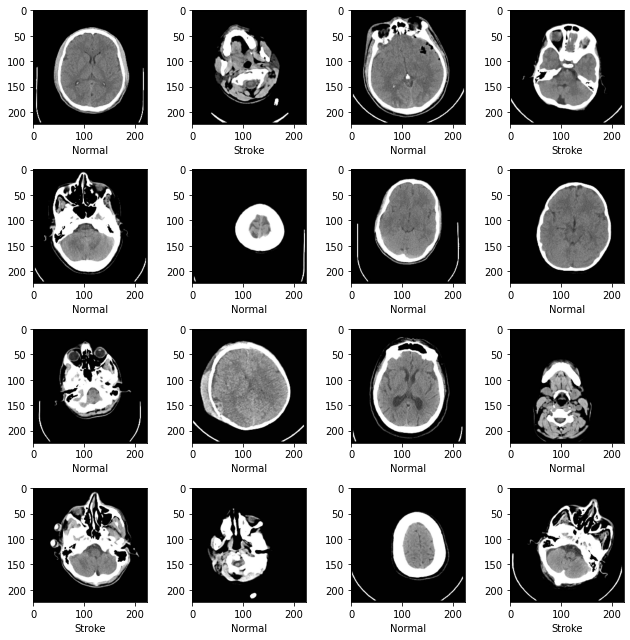

In [10]:
# show images from dataset
t_dict = train_set.class_indices
classes = list(t_dict.keys())  

images, labels = next(train_set)[:16]
fig, axes = plt.subplots(4, 4, figsize = (9, 9))

axes = axes.flatten()
for img, label, ax in zip(images, labels, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.set_xlabel(classes[label.astype(int)])
plt.tight_layout()
plt.show()

In [11]:
def get_callbacks(model_name):
    callbacks = []
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss', mode='min', save_best_only=True)
    callbacks.append(checkpoint)
    anne = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001, min_delta=0.00001, mode='auto') 
    callbacks.append(anne)
    return callbacks

# ViT B32

## Build Model

In [74]:
def plot_training_results(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [12]:
# build vit model with 32 patch_size
base_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016), activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006), activation = 'relu')(x)
x = Dropout(rate=.45, seed = 123)(x)        
predictions = Dense(1, activation = 'sigmoid')(x)
model = tf.keras.models.Model(inputs = base_model.input, outputs = predictions)

model.summary()

353263616/353253686 [==============================] - 53s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))        

In [14]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999), 
              metrics = metrics)

## Train Model

In [15]:
# train the model
start = datetime.now()
print(datetime.now())

callbacks = get_callbacks('vitb32')
history = model.fit(train_set,
                    epochs = NUM_EPOCHS,
                    validation_data = valid_set,
                    callbacks = [callbacks])

end = datetime.now()
print(end-start)

2021-12-23 21:57:52.473452
Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 5.9967 - tp: 214.0000 - fp: 369.0000 - tn: 772.0000 - fn: 446.0000 - BinaryAccuracy: 0.5475 - precision: 0.3671 - recall: 0.3242 - auc: 0.4906
Epoch 00001: val_loss improved from inf to 4.30555, saving model to model.vitb32.h5
57/57 [==============================] - 49s 375ms/step - loss: 5.9967 - tp: 214.0000 - fp: 369.0000 - tn: 772.0000 - fn: 446.0000 - BinaryAccuracy: 0.5475 - precision: 0.3671 - recall: 0.3242 - auc: 0.4906 - val_loss: 4.3056 - val_tp: 165.0000 - val_fp: 285.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_BinaryAccuracy: 0.3667 - val_precision: 0.3667 - val_recall: 1.0000 - val_auc: 0.4471 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 3.5999 - tp: 197.0000 - fp: 298.0000 - tn: 843.0000 - fn: 463.0000 - BinaryAccuracy: 0.5775 - precision: 0.3980 - recall: 0.2985 - auc: 0.5179
Epoch 00002: val_loss improved from 4.30555 to 2.76350

## Evaluate Model

In [16]:
# get results
results = model.evaluate(valid_set, steps = len(valid_set), verbose = 1, return_dict = True)

15/15 [==============================] - 2s 103ms/step - loss: 1.0378 - tp: 84.0000 - fp: 25.0000 - tn: 260.0000 - fn: 81.0000 - BinaryAccuracy: 0.7644 - precision: 0.7706 - recall: 0.5091 - auc: 0.7122


In [17]:
# show results
print('ViT:')
print('---------------')
print("ACCURACY:",(results['tp']+results['tn'])/(results['tp']+results['tn']+results['fp']+results['fn']))
print("Binary Accuracy:",(results['BinaryAccuracy']))
print("Precision:",(results['precision']))
print("Recall:",(results['recall']))
print("AUC:",(results['auc']))
print("F1 Score:",(2*((results['precision']*results['recall'])/((results['precision']+results['recall'])))))

ViT:
---------------
ACCURACY: 0.7644444444444445
Binary Accuracy: 0.7644444704055786
Precision: 0.7706422209739685
Recall: 0.5090909004211426
AUC: 0.7122169733047485
F1 Score: 0.6131386859011486


## Predict


Classification Report
              precision    recall  f1-score   support

      Normal       0.66      0.94      0.77       125
      Stroke       0.89      0.51      0.65       125

    accuracy                           0.72       250
   macro avg       0.77      0.72      0.71       250
weighted avg       0.77      0.72      0.71       250

Confusion Matrix
[[117   8]
 [ 61  64]]


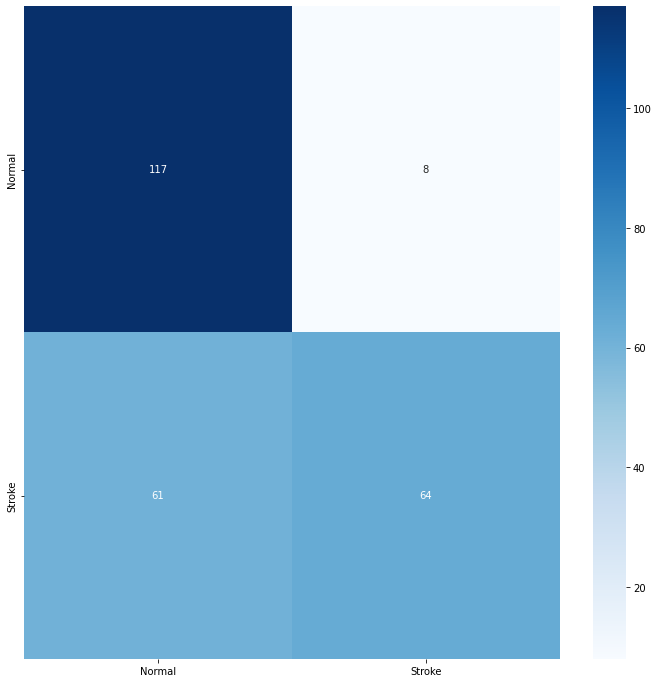

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Y_pred = model.predict(test_set)
y_pred = (Y_pred > 0.8).astype("int32")

print('\nClassification Report')
target_names = ['Normal', 'Stroke']
print(classification_report(test_set.classes, y_pred, target_names = target_names))

confusionmatrix = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(confusionmatrix)

plt.figure(figsize = (12, 12))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True, fmt="0.5g", xticklabels = target_names, yticklabels = target_names)

## Manifolds

In [22]:
def get_classes(data_set):
  f_classes = []
  idx_class = data_set.index_array
  for idc in idx_class:
    f_classes.append(data_set.classes[idc])
  return f_classes

In [108]:
import matplotlib.pyplot as plt

def plot_2d(embedding,labels,title):
  plt.figure(figsize=[15,10])
  plt.scatter(
      embedding[:, 0],
      embedding[:, 1],
      c=labels
  )
  plt.gca().set_aspect('equal', 'datalim')
  plt.title(title, fontsize=24)
  plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
  plt.show()

def plot_3d(embedding,labels, title):
  # plot the training data and overlayed test sample
  fig = plt.figure(figsize=[15,10])
  ax = plt.axes(projection ="3d")
  p = ax.scatter(
      embedding[:, 0],
      embedding[:, 1],
      embedding[:, 2],
      c=labels
  )
  plt.title(title, fontsize=24)
  fig.colorbar(p,boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
  plt.show()

### Create dataframe

In [53]:
from keras.applications.efficientnet import preprocess_input
from keras.preprocessing import image
import numpy as np

img_path = '/content/dataset/Brain_Data_Organised/Train/Stroke/97 (5).jpg'
img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

model_vit_notop = tf.keras.models.Model(inputs = model.input,
                                        outputs = model.get_layer("Transformer/encoder_norm").output)

vit_feature = model_vit_notop.predict(img_data)

print(vit_feature.shape)

(1, 50, 768)


In [66]:
# valid_set.reset()
# Y_pred_vit_notop = model_vit_notop.predict(valid_set)
train_set.reset()
Y_pred_vit_notop = model_vit_notop.predict(train_set)
y_pred_vit_notop = Y_pred_vit_notop.argmax(axis=1)

vit_feature_list = []

for y_pred in y_pred_vit_notop:
  vit_feature_np = np.array(y_pred)
  vit_feature_flatten = vit_feature_np.flatten()
  vit_feature_list.append(vit_feature_flatten)

vit_feature_list_np = np.array(vit_feature_list)

In [67]:
# create dataframe with 300 features for each image
import pandas as pd

df = pd.DataFrame()  

# labels = get_classes(valid_set)
labels = get_classes(train_set)

columns = []
columns.append('label')
for i in range(len(vit_feature_flatten[:768])):
  columns.append("feature_" + str(i+1))
  i = i+1

df = pd.DataFrame(columns=columns)

for i in range(len(labels)):
  vit_feature = vit_feature_list_np[i]
  df.at[i, columns[0]] = labels[i] 
  for j in range(len(vit_feature[:768])):
    df.at[i, columns[j+1]] = vit_feature[j]

In [68]:
df.head()

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_729,feature_730,feature_731,feature_732,feature_733,feature_734,feature_735,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,1,11,11,36,9,24,46,36,16,8,25,36,3,0,48,25,18,0,0,1,3,11,3,29,0,0,4,0,11,0,49,12,36,25,36,12,4,25,44,42,...,49,49,11,21,28,20,0,0,0,0,12,19,35,12,24,4,9,0,16,0,36,0,30,11,19,36,37,1,11,11,20,0,11,11,11,11,36,24,49,8
1,0,45,32,1,23,32,49,28,31,27,32,27,23,49,49,32,37,28,0,49,27,40,0,37,49,0,43,0,31,0,45,49,27,37,0,0,30,32,0,37,...,49,28,32,5,30,21,49,12,0,0,0,32,47,45,19,43,18,0,21,3,28,49,44,32,49,41,37,47,32,13,28,43,23,32,32,31,49,32,13,44
2,1,33,25,2,0,19,22,6,32,15,25,21,18,0,48,33,25,0,0,1,34,19,14,36,0,0,34,4,33,0,26,1,36,33,36,40,18,25,44,42,...,0,48,33,21,35,21,0,1,0,0,0,19,46,18,42,19,27,0,21,0,36,1,18,26,18,42,42,36,19,33,28,0,33,33,26,25,0,25,0,8
3,0,33,40,5,31,33,43,21,26,38,33,21,32,0,31,33,27,0,0,43,25,32,17,13,0,0,18,0,33,0,18,12,28,40,39,19,18,33,0,17,...,0,17,33,21,28,21,0,28,0,0,0,33,49,12,21,27,12,0,26,0,21,0,39,26,17,14,17,1,33,33,23,0,26,33,33,33,0,33,0,36
4,0,39,33,5,24,33,45,36,24,41,33,36,24,49,42,19,27,36,0,42,17,34,17,36,42,0,34,44,33,0,31,42,36,43,0,0,49,33,44,36,...,44,28,33,36,19,21,42,24,42,0,0,33,41,44,27,27,32,0,34,43,36,42,2,24,42,9,31,45,32,10,6,36,24,24,33,8,44,33,36,1


In [69]:
df[:15]

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,...,feature_729,feature_730,feature_731,feature_732,feature_733,feature_734,feature_735,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,1,11,11,36,9,24,46,36,16,8,25,36,3,0,48,25,18,0,0,1,3,11,3,29,0,0,4,0,11,0,49,12,36,25,36,12,4,25,44,42,...,49,49,11,21,28,20,0,0,0,0,12,19,35,12,24,4,9,0,16,0,36,0,30,11,19,36,37,1,11,11,20,0,11,11,11,11,36,24,49,8
1,0,45,32,1,23,32,49,28,31,27,32,27,23,49,49,32,37,28,0,49,27,40,0,37,49,0,43,0,31,0,45,49,27,37,0,0,30,32,0,37,...,49,28,32,5,30,21,49,12,0,0,0,32,47,45,19,43,18,0,21,3,28,49,44,32,49,41,37,47,32,13,28,43,23,32,32,31,49,32,13,44
2,1,33,25,2,0,19,22,6,32,15,25,21,18,0,48,33,25,0,0,1,34,19,14,36,0,0,34,4,33,0,26,1,36,33,36,40,18,25,44,42,...,0,48,33,21,35,21,0,1,0,0,0,19,46,18,42,19,27,0,21,0,36,1,18,26,18,42,42,36,19,33,28,0,33,33,26,25,0,25,0,8
3,0,33,40,5,31,33,43,21,26,38,33,21,32,0,31,33,27,0,0,43,25,32,17,13,0,0,18,0,33,0,18,12,28,40,39,19,18,33,0,17,...,0,17,33,21,28,21,0,28,0,0,0,33,49,12,21,27,12,0,26,0,21,0,39,26,17,14,17,1,33,33,23,0,26,33,33,33,0,33,0,36
4,0,39,33,5,24,33,45,36,24,41,33,36,24,49,42,19,27,36,0,42,17,34,17,36,42,0,34,44,33,0,31,42,36,43,0,0,49,33,44,36,...,44,28,33,36,19,21,42,24,42,0,0,33,41,44,27,27,32,0,34,43,36,42,2,24,42,9,31,45,32,10,6,36,24,24,33,8,44,33,36,1
5,0,19,26,5,27,26,36,28,49,16,26,42,24,13,49,33,43,43,0,49,27,36,49,0,22,26,38,0,39,0,38,43,42,42,43,0,35,26,0,42,...,49,49,25,13,39,27,49,7,43,0,0,26,16,18,49,26,39,0,0,41,42,1,13,26,49,42,24,2,26,13,13,39,24,24,33,9,43,26,0,8
6,1,33,38,5,16,11,46,21,12,41,39,42,23,42,36,11,12,0,0,1,9,38,42,43,0,0,38,0,39,0,38,4,42,11,10,4,39,11,4,42,...,0,4,19,21,44,21,0,4,0,0,0,11,35,34,42,11,12,0,0,42,48,4,38,11,38,42,42,9,33,39,35,0,39,10,19,14,0,11,0,8
7,0,33,11,5,9,11,45,21,3,41,10,21,30,43,43,11,12,0,0,1,9,11,9,43,0,0,38,0,10,0,38,4,49,10,43,4,23,10,3,49,...,0,37,11,21,28,21,0,15,12,0,0,11,35,12,49,10,12,0,21,43,49,3,30,11,38,49,49,44,33,11,28,8,10,10,33,11,0,10,0,44
8,0,25,25,6,38,25,44,28,30,41,25,13,24,30,39,25,17,39,0,49,10,25,3,38,0,0,25,0,25,0,25,38,27,17,16,38,4,17,3,16,...,38,30,10,14,27,13,30,28,0,0,0,19,49,4,19,25,4,0,17,0,16,38,10,25,24,14,16,2,25,38,34,8,25,25,25,25,0,25,0,44
9,0,31,31,5,22,24,39,49,17,8,24,49,22,49,43,24,0,43,0,6,30,31,35,49,0,0,32,49,24,0,30,43,49,24,38,39,17,24,18,37,...,39,39,49,49,49,19,43,18,0,0,0,23,28,17,49,24,17,0,32,0,49,43,29,30,29,49,37,1,31,30,38,0,24,24,24,30,43,24,0,49


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1801 entries, 0 to 1800
Columns: 769 entries, label to feature_768
dtypes: object(769)
memory usage: 10.7+ MB


In [81]:
y = df.loc[:,'label'].values
x = df.loc[:,'feature_1':].values

In [88]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
x = StandardScaler().fit_transform(x)

### Isomap (Isometric  Feature  Mapping)

In [89]:
from sklearn.manifold import Isomap
import time

start = time.time()
isomap = Isomap(n_components=3).fit_transform(x) 
print('Duration: {} seconds'.format(time.time() - start))

Duration: 1.8389768600463867 seconds


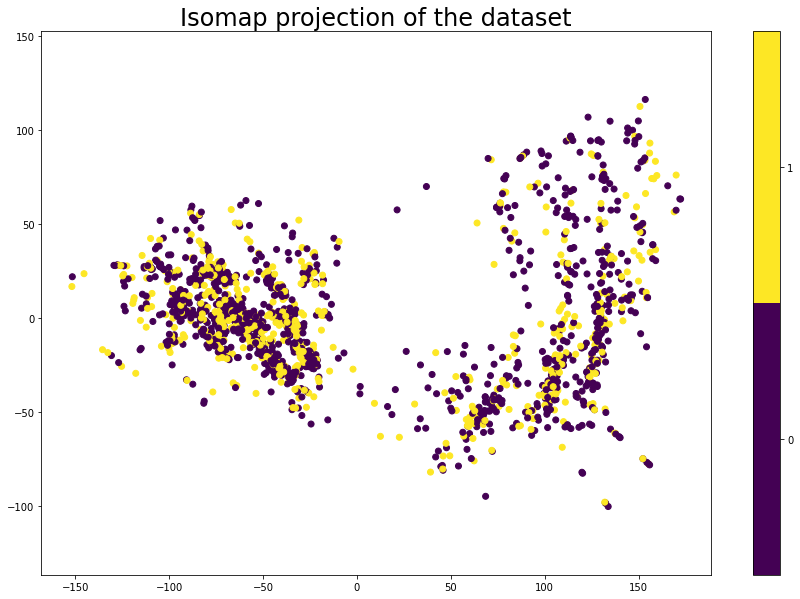

In [109]:
plot_2d(isomap, labels, "Isomap projection of the dataset")

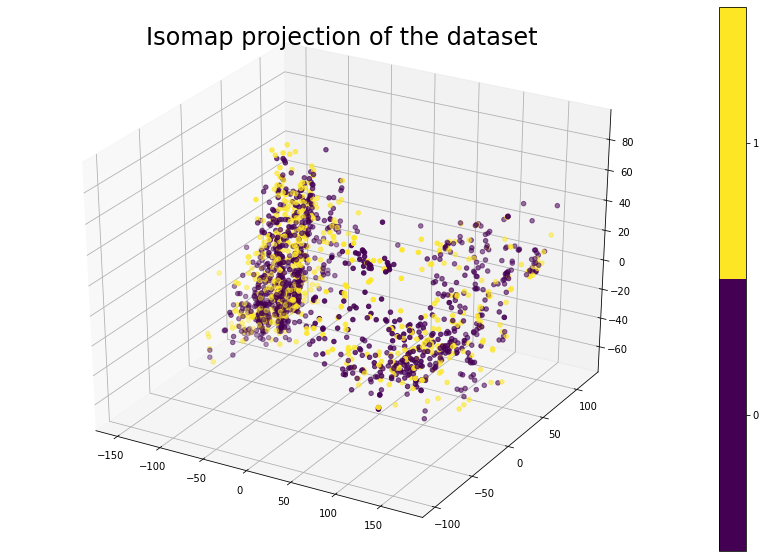

In [110]:
plot_3d(isomap, labels, "Isomap projection of the dataset")

### LE (Laplacian  Eigenmaps)

In [92]:
from sklearn.manifold import SpectralEmbedding

start = time.time()
le = SpectralEmbedding(n_components=3, random_state=0,eigen_solver="arpack").fit_transform(x) 
print('Duration: {} seconds'.format(time.time() - start))

Duration: 1.3197722434997559 seconds


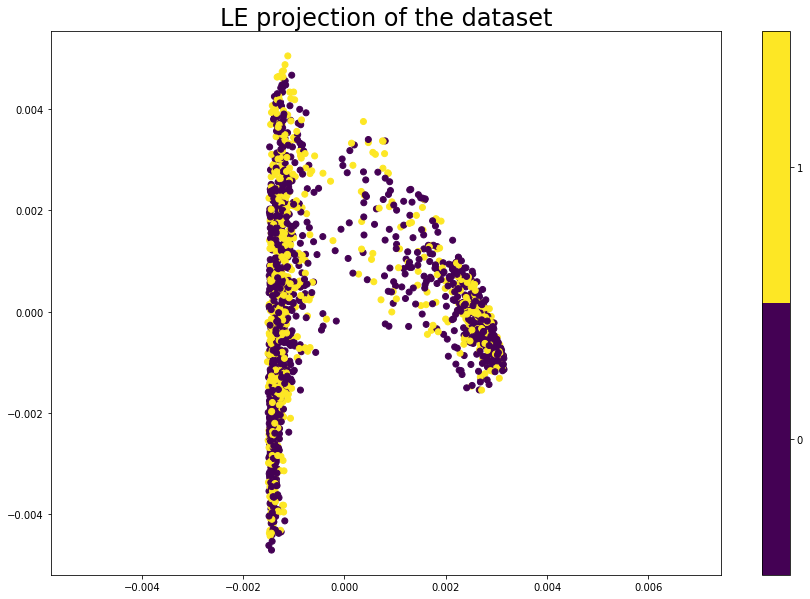

In [111]:
plot_2d(le, labels, "LE projection of the dataset")

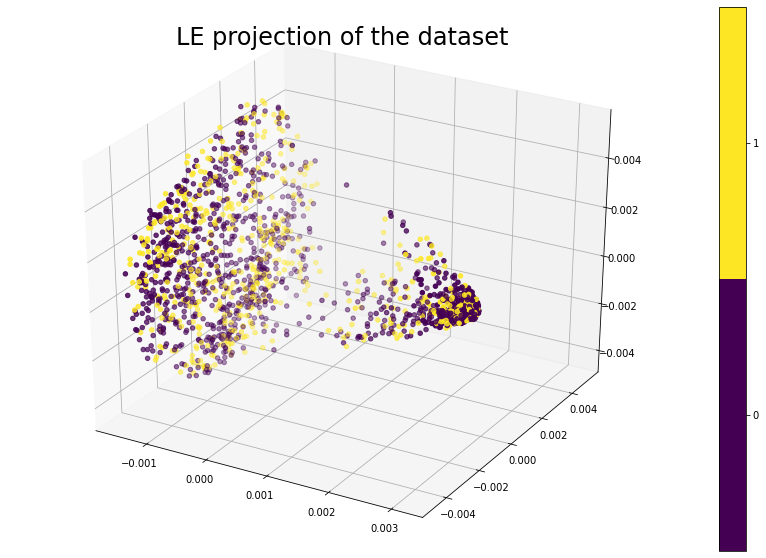

In [112]:
plot_3d(le, labels, "LE projection of the dataset")

### LLE (Locally Linear Embedding)

In [95]:
from sklearn.manifold import LocallyLinearEmbedding

start = time.time()
lle = LocallyLinearEmbedding(n_components=3).fit_transform(x) 
print('Duration: {} seconds'.format(time.time() - start))

Duration: 0.506159782409668 seconds


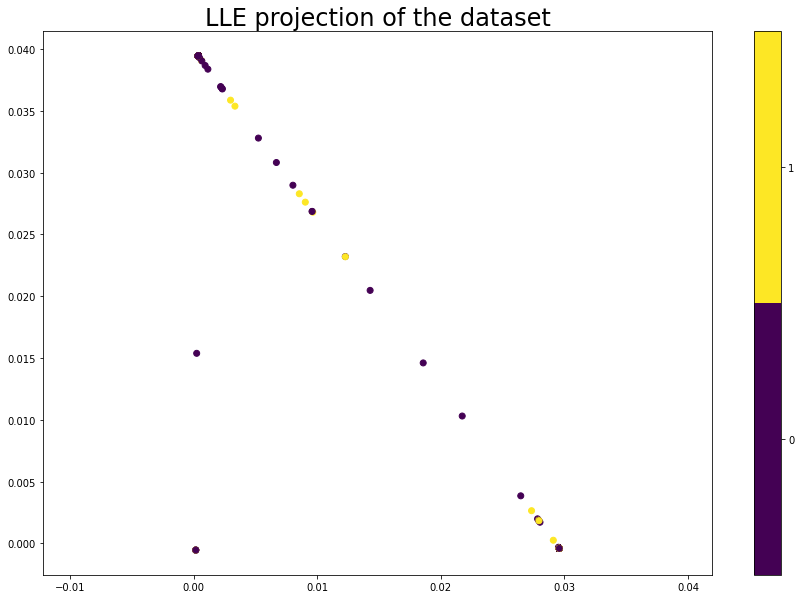

In [113]:
plot_2d(lle, labels, "LLE projection of the dataset")

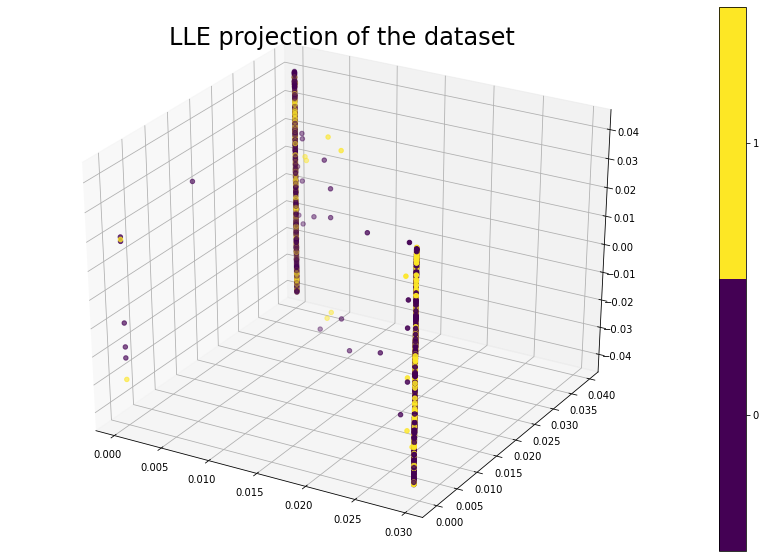

In [114]:
plot_3d(lle, labels, "LLE projection of the dataset")

### T-SNE (t-Distribution  Stochastic  Neighbor  Embeddings)

In [98]:
#TSNE
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

start = time.time()
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x)
tsne = TSNE(random_state = 42, n_components=3,verbose=True, perplexity=20, n_iter=400).fit_transform(pca_result_50)
print('Duration: {} seconds'.format(time.time() - start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1801 samples in 0.001s...
[t-SNE] Computed neighbors for 1801 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1801
[t-SNE] Computed conditional probabilities for sample 1801 / 1801
[t-SNE] Mean sigma: 5.831053
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.256302
[t-SNE] KL divergence after 400 iterations: 1.026767
Duration: 25.72361469268799 seconds


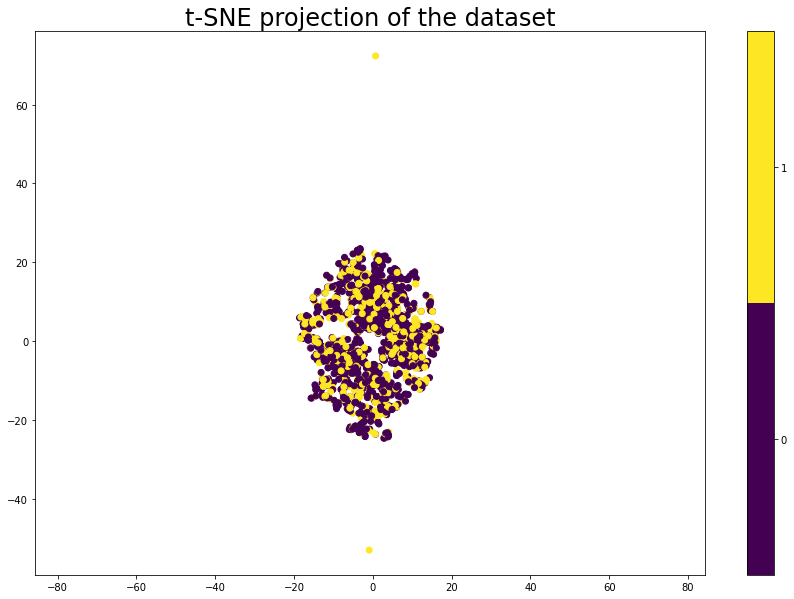

In [115]:
plot_2d(tsne, labels, "t-SNE projection of the dataset")

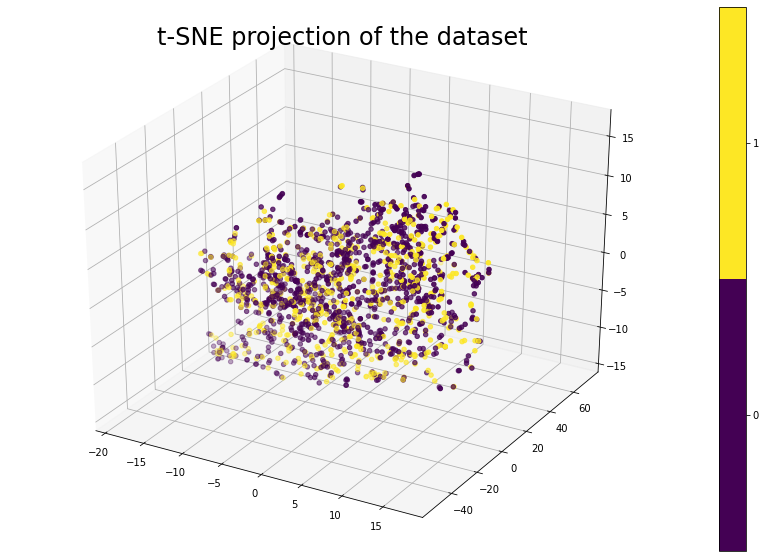

In [116]:
plot_3d(tsne, labels, "t-SNE projection of the dataset")

### UMAP (Uniform  Manifold  Approximation  and  Projection)

In [42]:
!pip install umap-learn[plot]

     |████████████████████████████████| 86 kB 3.0 MB/s 
     |████████████████████████████████| 1.1 MB 11.0 MB/s 
     |████████████████████████████████| 15.8 MB 25.5 MB/s 
     |████████████████████████████████| 76 kB 5.9 MB/s 
     |████████████████████████████████| 132 kB 53.8 MB/s 
     |████████████████████████████████| 802 kB 48.4 MB/s 
     |████████████████████████████████| 802 kB 50.1 MB/s 
     |████████████████████████████████| 793 kB 45.1 MB/s 
     |████████████████████████████████| 793 kB 28.5 MB/s 
     |████████████████████████████████| 791 kB 68.5 MB/s 
     |████████████████████████████████| 786 kB 45.3 MB/s 
     |████████████████████████████████| 779 kB 60.1 MB/s 
     |████████████████████████████████| 778 kB 58.4 MB/s 
     |████████████████████████████████| 776 kB 66.0 MB/s 
     |████████████████████████████████| 769 kB 47.8 MB/s 
     |████████████████████████████████| 766 kB 67.2 MB/s 
     |████████████████████████████████| 1.0 MB 70.2 MB/s 
     |███████████

UMAP Unsupervised

In [102]:
#UMAP
import umap

# unsupervised
start = time.time()
reducer = umap.UMAP(random_state=42,n_components=3)
umap_un = reducer.fit_transform(x)
print('Duration: {} seconds'.format(time.time() - start))

Duration: 8.124009847640991 seconds


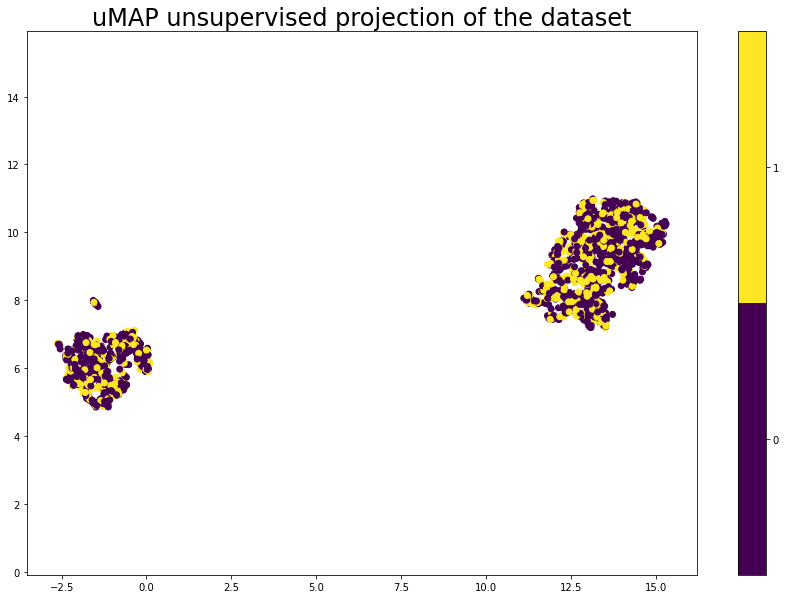

In [117]:
plot_2d(umap_un, labels, "uMAP unsupervised projection of the dataset")

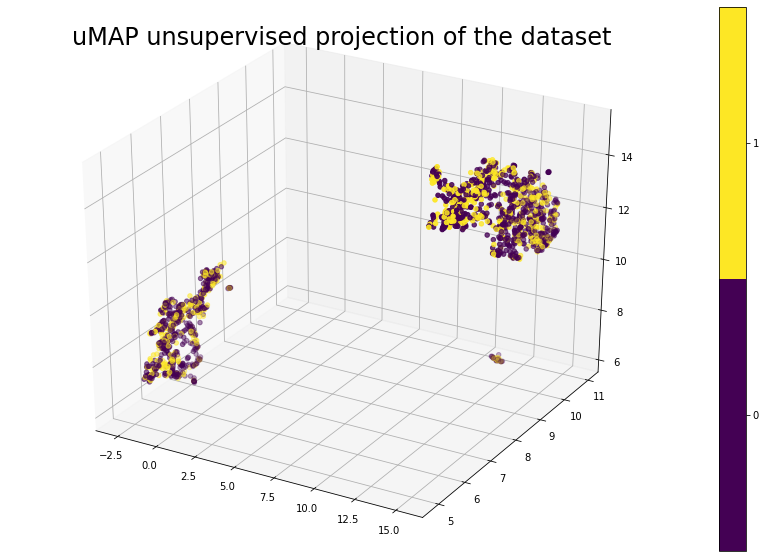

In [118]:
plot_3d(umap_un, labels, "uMAP unsupervised projection of the dataset")

UMAP Supervised

In [105]:
#UMAP
import umap

# supervised
start = time.time()
reducer = umap.UMAP(n_components = 3, n_neighbors = 20, verbose = True)
umap_transformer = reducer.fit(x, labels)
umap_su = umap_transformer.transform(x)
print('Duration: {} seconds'.format(time.time() - start))

UMAP(n_components=3, n_neighbors=20, verbose=True)
Thu Dec 23 22:46:12 2021 Construct fuzzy simplicial set
Thu Dec 23 22:46:14 2021 Finding Nearest Neighbors
Thu Dec 23 22:46:15 2021 Finished Nearest Neighbor Search
Thu Dec 23 22:46:15 2021 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Thu Dec 23 22:46:20 2021 Finished embedding
Duration: 7.85955548286438 seconds


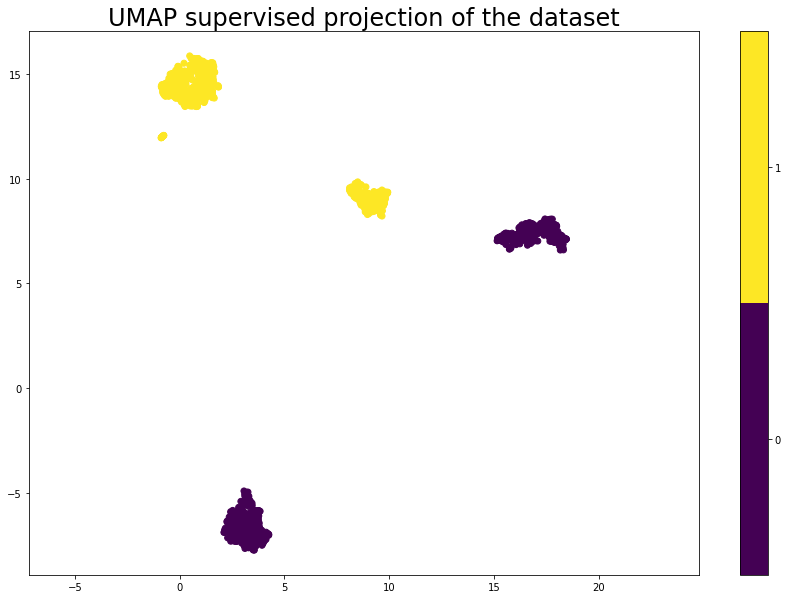

In [119]:
plot_2d(umap_su, labels, "UMAP supervised projection of the dataset")

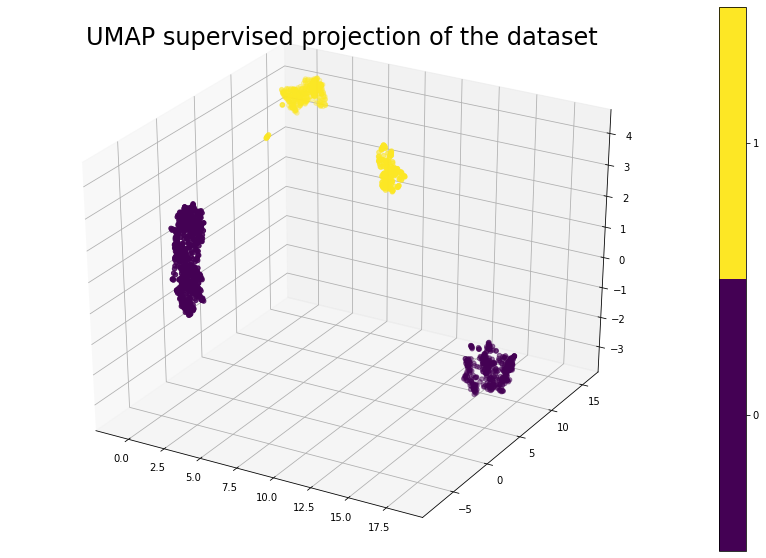

In [120]:
plot_3d(umap_su, labels, "UMAP supervised projection of the dataset")